# Text Analytics


# Assignment 1

### *Submitted by:*  

**Zena Drakou | Marissa Hausman | Hitesh Prabhu | Chase Slocum | Yawen Ye - MSBA 2017 **

**Sept 6, 2016**

### Initial Setup:

1. Importing libraries
2. Reading dataset

In [1]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix

import random
import string
import math

In [2]:
job = pd.read_csv("files\Train_rev1.csv")
salary = job["SalaryNormalized"]

quantile_75 = salary.quantile(q = 0.75)
job["salary_category"] = ""
job.loc[job["SalaryNormalized"] >= quantile_75, "salary_category"] = "High Salary"
job.loc[job["SalaryNormalized"] < quantile_75, "salary_category"] = "Low Salary"

Creating sample size to run the notebook on

In [3]:
subset_size = 10000
feature_set = subset_size/2

## Part A 

#### A1 - What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

In [4]:
# Creating 2 lists 'des' and 'cat' for the description and the category respectively
descriptions = []
categories = []

# Function to encode the text to 'utf-8' before tokenization
def tolist_utf8(h):
    descriptions.append(h.decode('utf-8').lower())

# put the values from salary_category column into list
def tolist(h):
    categories.append(h)   

dess = job["FullDescription"]
dess.map(tolist_utf8)

cate = job["salary_category"]
cate.map(tolist)

descriptions_subset = []

# picking a subset of the job-descriptions dataset
for i in range(subset_size):
    descriptions_subset.append(nltk.word_tokenize(descriptions[i]))

# Creating one list with all the words 
jobdes_bow = []
for i in range(subset_size):
    for j in range(len(descriptions_subset[i])):
        jobdes_bow.append(descriptions_subset[i][j])

jobdes_pos_tagged = nltk.pos_tag(jobdes_bow)
jobdes_pos_tagged_freq = nltk.FreqDist(tag_single for (word, tag_single) in jobdes_pos_tagged)
jobdes_pos_tagged_freq.most_common(5)

[('NN', 626738),
 ('JJ', 274481),
 ('IN', 258077),
 ('DT', 193658),
 ('NNS', 191164)]

_The top 5 parts of speech were found to be Nouns (singular), Adjectives, Preposition/conjunctions, Determiners and Common Nouns (Plural)_

#### A2 - Zipf's law: Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

#### Code reference from this link: 
https://www.garysieling.com/blog/exploring-zipfs-law-with-python-nltk-scipy-and-matplotlib

[[ 1.          0.91329394]
 [ 0.91329394  1.        ]]


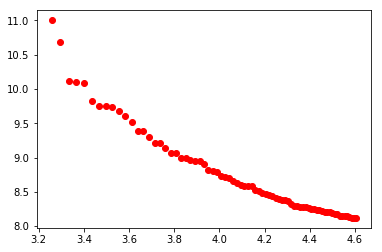

In [5]:
top100_wordcount_list = []
jobdes_word_freq = nltk.FreqDist(word for (word, tag_single) in jobdes_pos_tagged)

# putting the most common 100 words with their counts into a list
for word, frequency in jobdes_word_freq.most_common(100):
    top100_wordcount_list.append((word, frequency))

import scipy.stats as ss
 
amb = [(w, c, len(wordnet.synsets(w))) for (w, c) in top100_wordcount_list if len(wordnet.synsets(w)) > 0]
 
amb_p_rank = ss.rankdata([p for (w, c, p) in amb])
amb_c_rank = ss.rankdata([c for (w, c, p) in amb])
 
amb_ranked = zip(amb, amb_p_rank, amb_c_rank)
 
print np.corrcoef(amb_c_rank, [math.log(c) for (w, c, p) in amb])

import matplotlib
rev = [100-r+1 for r in amb_c_rank]

plt.plot([math.log(c) for c in rev], [math.log(c) for (w, c, p) in amb], 'ro')

# plt.plot([c for (w,c,p) in amb], [p for (w,c,p) in amb], 'bs')

_This corpus follows Zipf's Law_

#### A3: If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [6]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words("english"))
# remove it if you need punctuation
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','****']) 

jobdes_cleaned = []
jobdes_lemmatized = []
jobdes_nostopwords = []

# pick a small subset of the dataset
for i in range(subset_size):
    word_tokenize = nltk.word_tokenize(descriptions[i])
    lemma_word = map(lambda x: lemmatizer.lemmatize(x), word_tokenize)
    jobdes_lemmatized.append(lemma_word)
    no_stop = filter(lambda x: x not in stop_words, word_tokenize)
    jobdes_nostopwords.append(no_stop)
    cleaned_text = filter(lambda x: x not in stop_words, lemma_word)
    jobdes_cleaned.append(cleaned_text)

jobdes_bow_cleaned = []
jobdes_bow_lemmatized = []
jobdes_bow_nostopwords = []

for i in range(subset_size):
    for j in range(len(jobdes_cleaned[i])):
        jobdes_bow_cleaned.append(jobdes_cleaned[i][j])
    for k in range(len(jobdes_lemmatized[i])):
        jobdes_bow_lemmatized.append(jobdes_lemmatized[i][k])
    for l in range(len(jobdes_nostopwords[i])):
        jobdes_bow_nostopwords.append(jobdes_nostopwords[i][l])

jobdes_bow_cleaned_freq = nltk.FreqDist(jobdes_bow_cleaned)
jobdes_bow_lemmatized_freq = nltk.FreqDist(jobdes_bow_lemmatized)
jobdes_bow_nostopwords_freq = nltk.FreqDist(jobdes_bow_nostopwords)

# print out the most common 50 words with their count
for word, frequency in jobdes_bow_cleaned_freq.most_common(10):
    print('%s: %d' % (word, frequency)).encode('utf-8')

experience: 17298
work: 12311
care: 11975
role: 11796
client: 11600
team: 11055
working: 10014
service: 9463
within: 9245
manager: 9103


## Part B

#### B1 - Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)?

In [7]:
document = []

# pick a small subset of the dataset
for i in range(subset_size):
    tup = (nltk.word_tokenize(descriptions[i]), categories[i])
    document.append(tup)

# we have to shuffle the documents to test on seperate data that did not train again.
random.shuffle(document)

# reusing descriptions_subset, jobdes_bow, jobdes_word_freq

# choose words having the highest frequency among all words as our features, the number of feature = data_size/2
jobdes_bow_freq = nltk.FreqDist(jobdes_bow)
word_feature = list(jobdes_bow_freq.keys())[:feature_set]

# This function will return whether or not the word in feature set appear among the words in document
def find_features(document):
    words = set(document)
    features = {}
    for w in word_feature:
        features[w] = (w in words) # return boolean if the 500 words feature appear in the document or not

    return features

# find_feature(description) gives whether or not top 500 words appear in each job description 
featuresets = [(find_features(description), category) for (description, category) in document]

# set that we'll train our classifier with
subset_size_mid = subset_size/2
training_set = featuresets[:subset_size_mid]
# set that we'll test against.
testing_set = featuresets[subset_size_mid:]
testing_set_mod = [x[0] for x in testing_set]

# Running Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
predicted_categories_NaiveBayes =  classifier.classify_many(testing_set_mod)
actual_categories = [x[1] for x in testing_set]

# Printing confusion matrix
cm = nltk.ConfusionMatrix(actual_categories, predicted_categories_NaiveBayes)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

('Classifier accuracy percent:', 78.68)
            |             H |
            |      L      i |
            |      o      g |
            |      w      h |
            |               |
            |      S      S |
            |      a      a |
            |      l      l |
            |      a      a |
            |      r      r |
            |      y      y |
------------+---------------+
 Low Salary | <68.8%> 12.4% |
High Salary |   8.9%  <9.9%>|
------------+---------------+
(row = reference; col = test)



_The model does well on predicting Low Salary correctly (~85% Precision) and much worse on predicting High Salary (~45% Precision) _

#### B2 - Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained.

In [8]:
lemmatizer = WordNetLemmatizer()

document_lemmatized = []

# reusing descriptions_subset, jobdes_bow, jobdes_word_freq, jobdes_bow_lemmatized, jobdes_bow_nostopwords,
# jobdes_bow_lemmatized_freq, jobdes_bow_nostopwords_freq, function find_features

# pick a small subset of the dataset
for i in range(subset_size):
    word_tokenize = nltk.word_tokenize(descriptions[i])
    lemma_word = map(lambda x: lemmatizer.lemmatize(x), word_tokenize)
    tup = (lemma_word, categories[i])
    document_lemmatized.append(tup)
    
random.shuffle(document_lemmatized)

jobdes_bow_lemmatized_freq = nltk.FreqDist(jobdes_bow_lemmatized)
# choose the top 500 words having the highest frequency among all words as our features
word_feature = list(jobdes_bow_lemmatized_freq.keys())[:feature_set]

# find_feature(description) gives whether or not top 500 words appear in each job description 
featuresets = [(find_features(description), category) for (description, category) in document_lemmatized]

# set that we'll train our classifier with
subset_size_mid = subset_size/2
training_set = featuresets[:subset_size_mid]
# set that we'll test against.
testing_set = featuresets[subset_size_mid:]
testing_set_mod = [x[0] for x in testing_set]

# Running Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
predicted_categories_NaiveBayes =  classifier.classify_many(testing_set_mod)
actual_categories = [x[1] for x in testing_set]

# Printing confusion matrix
cm = nltk.ConfusionMatrix(actual_categories, predicted_categories_NaiveBayes)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

('Classifier accuracy percent:', 79.2)
            |             H |
            |      L      i |
            |      o      g |
            |      w      h |
            |               |
            |      S      S |
            |      a      a |
            |      l      l |
            |      a      a |
            |      r      r |
            |      y      y |
------------+---------------+
 Low Salary | <69.7%> 12.0% |
High Salary |   8.8%  <9.5%>|
------------+---------------+
(row = reference; col = test)



_The accuracy overall increases to 79.2 from 78.7: The in-class precision also increase in the relative magnitude_

#### B3 - Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2. Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.   

In [9]:
stop_words = set(stopwords.words("english"))  # load stopwords
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','****']) 

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

document_nostopwords = []

# reusing descriptions_subset, jobdes_bow, jobdes_word_freq, jobdes_bow_lemmatized, jobdes_bow_nostopwords,
# jobdes_bow_lemmatized_freq, jobdes_bow_nostopwords_freq, function find_features

# pick a small subset of the dataset
for i in range(subset_size):
    word_tokenize = nltk.word_tokenize(descriptions[i])
    cleaned_text = filter(lambda x: x not in stop_words, word_tokenize)
    tup = (cleaned_text, categories[i])
    document_nostopwords.append(tup)
    
random.shuffle(document_nostopwords)

jobdes_bow_nostopwords_freq = nltk.FreqDist(jobdes_bow_nostopwords)

# choose the top 500 words having the highest frequency among all words as our features
word_feature = list(jobdes_bow_nostopwords_freq.keys())[:feature_set]

# find_feature(description) gives whether or not top 500 words appear in each job description 
featuresets = [(find_features(description), category) for (description, category) in document_nostopwords]

# set that we'll train our classifier with
subset_size_mid = subset_size/2
training_set = featuresets[:subset_size_mid]
# set that we'll test against.
testing_set = featuresets[subset_size_mid:]
testing_set_mod = [x[0] for x in testing_set]

# Running Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
predicted_categories_NaiveBayes =  classifier.classify_many(testing_set_mod)
actual_categories = [x[1] for x in testing_set]

# Printing confusion matrix
cm = nltk.ConfusionMatrix(actual_categories, predicted_categories_NaiveBayes)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

# Printing indicative words for high salary and low salary
print classifier.show_most_informative_features(50)

('Classifier accuracy percent:', 78.18)
            |             H |
            |      L      i |
            |      o      g |
            |      w      h |
            |               |
            |      S      S |
            |      a      a |
            |      l      l |
            |      a      a |
            |      r      r |
            |      y      y |
------------+---------------+
 Low Salary | <68.6%> 12.7% |
High Salary |   9.1%  <9.6%>|
------------+---------------+
(row = reference; col = test)

Most Informative Features
                 teacher = True           Low Sa : High S =     21.0 : 1.0
                    rota = True           Low Sa : High S =     19.1 : 1.0
                 exploit = True           High S : Low Sa =     15.5 : 1.0
             immigration = True           Low Sa : High S =     13.7 : 1.0
                 cooking = True           Low Sa : High S =     13.5 : 1.0
                     ibm = True           High S : Low Sa =     12.6 : 1.0
   

_The overall accuracy remains around the same as B2_

#### B4 - Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?  

In [10]:
document_pos_bigrams = []

# pick a small subset of the dataset
for i in range(subset_size):
    word_tokenize = nltk.word_tokenize(descriptions[i])
    word_tokenize_pos = nltk.pos_tag(word_tokenize)
    pos = [x[1] for x in word_tokenize_pos]
    pos_bigram = nltk.ngrams(pos,2)
    tup = (word_tokenize + list(pos_bigram), categories[i])
    document_pos_bigrams.append(tup)
    
random.shuffle(document_pos_bigrams)

# reusing descriptions_subset, jobdes_bow, jobdes_word_freq

# choose the top 500 pos-bigrams having the highest frequency among all words as our features
jobdes_pos = nltk.pos_tag(jobdes_bow)
jobdes_pos_only = [x[1] for x in jobdes_pos]
jobdes_pos_bigrams =  nltk.ngrams(jobdes_pos_only,2)
# print document_pos_bigrams[:10]
jobdes_pos_bigrams_freq = nltk.FreqDist(jobdes_pos_bigrams)
word_feature_1 = list(jobdes_pos_bigrams_freq.keys())[:feature_set]
word_feature_2 = list(jobdes_bow_freq.keys())[:feature_set]
word_feature = word_feature_2 + word_feature_1
# document_pos_bigrams = document + document_pos_bigrams

def find_bigram_features(document_pos_bigrams):
    words = set(document_pos_bigrams)
    features = {}
#     count = 0
    for w_bigram in word_feature:
        features[w_bigram] = (w_bigram in words) # return boolean if the 500 words feature appear in the document or not
#         for ww in words:
#             if w == ww:
#                 count += 1
#         features[w] = (count) # return count the each 50 words feature appear in the document
    return features

# find_feature(description) gives whether or not top 500 words appear in each job description 
featuresets = [(find_bigram_features(description), category) for (description, category) in document_pos_bigrams]

# set that we'll train our classifier with
subset_size_mid = subset_size/2
training_set = featuresets[:subset_size_mid]
# set that we'll test against.
testing_set = featuresets[subset_size_mid+1:]
testing_set_mod = [x[0] for x in testing_set]

# Running Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
predicted_categories_NaiveBayes =  classifier.classify_many(testing_set_mod)
actual_categories = [x[1] for x in testing_set]

# Printing confusion matrix
cm = nltk.ConfusionMatrix(actual_categories, predicted_categories_NaiveBayes)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

# Printing indicative words for high salary and low salary
print classifier.show_most_informative_features(50)

('Classifier accuracy percent:', 77.29545909181836)
            |             H |
            |      L      i |
            |      o      g |
            |      w      h |
            |               |
            |      S      S |
            |      a      a |
            |      l      l |
            |      a      a |
            |      r      r |
            |      y      y |
------------+---------------+
 Low Salary | <67.0%> 13.6% |
High Salary |   9.1% <10.3%>|
------------+---------------+
(row = reference; col = test)

Most Informative Features
              initiation = True           High S : Low Sa =     30.9 : 1.0
                 j****ee = True           High S : Low Sa =     22.1 : 1.0
           ("''", 'NNS') = True           High S : Low Sa =     19.2 : 1.0
                     ibm = True           High S : Low Sa =     19.2 : 1.0
             integrating = True           High S : Low Sa =     18.6 : 1.0
                    rota = True           Low Sa : High S =     17

_The overall performance of the model does not change significantly_